In [180]:
"""
read_ASOS108(): 서울 ASOS 자료를 pandas DataFrame 형태로 읽음
"""
import pandas as pd
import numpy as np
import os
def read_ASOS108():
    inpath = "../../data/ASOS108"
    fnlist = os.listdir(inpath)
    dfs = []
    for fn in fnlist:
        df = pd.read_csv(os.path.join(inpath, fn), encoding='cp949')
        dfs.append(df)
    return pd.concat(dfs)
    
"""
process_cols(df, use_cols): 입력자료로 사용할 열 추출 및 생성, 자료의 전처리 단계
"""

def process_cols(df, use_cols):
    df['일강수량(mm)'] = df['일강수량(mm)'].fillna(0)
    df1 = df[use_cols].dropna()
    df1['datetime'] = pd.to_datetime(df1['일시'])
    df1['year'] = df1['datetime'].dt.year
    df1['month'] = df1['datetime'].dt.month
    df1['day'] = df1['datetime'].dt.day
    return df1.sort_values(by='datetime')

In [181]:
def remove_seasonal_cycle(df, use_cols):
    df['day_of_year'] = df['datetime'].dt.strftime('%m-%d')  # MM-DD 형식
    
    for col in use_cols[1:]:  # '일시' 제외
        seasonal_cycle = df.groupby('day_of_year')[col].mean()
        
        # 2월 29일 처리
        if '02-29' in seasonal_cycle:
            if '02-28' in seasonal_cycle and '03-01' in seasonal_cycle:
                seasonal_cycle['02-29'] = (seasonal_cycle['02-28'] + seasonal_cycle['03-01']) / 2
        
        df[f'{col}_seasonal_cycle'] = df['day_of_year'].map(seasonal_cycle)
        df[f'{col}_detrended'] = df[col] - df[f'{col}_seasonal_cycle']
    
    return df.drop(columns=['day_of_year'] + [f'{col}_seasonal_cycle' for col in use_cols[1:]])

In [182]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

def split_data_scale(df, date1, date2, batch_size=64):
    datetime = df['datetime'][df['datetime'] >= date2]

    """
    date1: 학습(train)과 검증(valid)을 나누는 기준 날짜
    date2: 검증(valid)과 테스트(test)를 나누는 기준 날짜
    """
    # 데이터 분할
    train_df = df[df['datetime'] < date1].drop('datetime', axis=1)
    valid_df = df[(df['datetime'] >= date1) & (df['datetime'] < date2)].drop('datetime', axis=1)
    test_df  = df[df['datetime'] >= date2].drop('datetime', axis=1)

    # X, y 분리
    train_X, train_y = train_df.drop('Y', axis=1), train_df['Y']
    valid_X, valid_y = valid_df.drop('Y', axis=1), valid_df['Y']
    test_X, test_y   = test_df.drop('Y', axis=1), test_df['Y']

    

    # MinMaxScaler 적용 (train_X 기준으로 fit)
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)  # train에 fit 후 변환
    valid_X_scaled = scaler.transform(valid_X)      # train 기준으로 transform만 수행
    test_X_scaled  = scaler.transform(test_X)

    # PyTorch Tensor 변환
    train_X_tensor = torch.tensor(train_X_scaled, dtype=torch.float32)
    valid_X_tensor = torch.tensor(valid_X_scaled, dtype=torch.float32)
    test_X_tensor  = torch.tensor(test_X_scaled, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32).view(-1, 1)
    valid_y_tensor = torch.tensor(valid_y.values, dtype=torch.float32).view(-1, 1)
    test_y_tensor  = torch.tensor(test_y.values, dtype=torch.float32).view(-1, 1)

    # DataLoader 생성 (train/valid만 사용)
    train_loader = DataLoader(TensorDataset(train_X_tensor, train_y_tensor), batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(TensorDataset(valid_X_tensor, valid_y_tensor), batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_X_tensor, test_y_tensor, datetime

In [183]:
df_raw = read_ASOS108()

use_cols = ['일시', '평균기온(°C)']#, '평균 풍속(m/s)', '평균 이슬점온도(°C)']
# use_cols = ['일시', '평균기온(°C)', '일강수량(mm)', '평균 풍속(m/s)', 
#         '평균 이슬점온도(°C)', '평균 상대습도(%)', 
#         '평균 현지기압(hPa)', '평균 전운량(1/10)', '합계 일사량(MJ/m2)']
df_raw1 = process_cols(df_raw, use_cols)
# """
# raw
# """
# target = '평균기온(°C)'
# df_raw1['Y'] = df_raw1[target].shift(-1)
# df_raw1.drop(['일시'], axis=1, inplace=True)
# df_raw1 = df_raw1.dropna()


# """
# deseasonalized
# """
df_raw1 = remove_seasonal_cycle(df_raw1, use_cols)
target = '평균기온(°C)_detrended'
df_raw1['Y'] = df_raw1[target].shift(-1)

df_raw1 = df_raw1.iloc[:-1]

use_cols_detrend = df_raw1.columns
use_cols_detrend = [ col for col in use_cols_detrend if col not in use_cols]
df_raw1 = df_raw1[use_cols_detrend]
df_raw1 = df_raw1.dropna()

# 자료 전처리
train_loader, valid_loader, test_X, test_y, datetime = split_data_scale(df_raw1, '2019-01-01','2022-01-01')


In [184]:
import torch.nn as nn
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(len(use_cols)+2, 8),  
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
    
    def forward(self, x):
        return self.network(x)

In [185]:
import random
def set_random_seed(seed):
    # Python의 기본 랜덤 시드 설정
    random.seed(seed)

    # NumPy의 랜덤 시드 설정
    np.random.seed(seed)

    # PyTorch의 랜덤 시드 설정
    torch.manual_seed(seed)  # CPU에서 사용되는 시드
    
    # CuDNN에서 사용하는 비결정적 알고리즘을 비활성화 (결정적 실행을 위해)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # 성능 최적화를 위한 자동 튜닝 비활성화 (결정적 실행을 보장)

In [186]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# 모델 학습 함수 (DataLoader 사용)
def train_model(model, train_loader, valid_loader, epochs=100):
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_model_path = 'best_model.pth'
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)  # y의 차원 맞추기
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in valid_loader:
                valid_outputs = model(batch_X)
                loss = criterion(valid_outputs, batch_y)  # y의 차원 맞추기
                valid_loss += loss.item()
        
        valid_loss /= len(valid_loader)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        scheduler.step(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), best_model_path)
            print(f'Epoch {epoch}: New best model saved with valid_loss: {best_valid_loss:.4f}')
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    return train_losses, valid_losses, best_model_path
# 모델 학습 실행

corrs, rmses = [], []

for seed in range(10):
    print("-------------------------")
    print(seed)
    print("-------------------------")
    set_random_seed(seed)
    model = DNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)
    train_losses, valid_losses, best_model_path = train_model(model, train_loader, valid_loader)
    

    # 모델 로드 및 테스트 예측
    best_model = DNN()
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()

    with torch.no_grad():
        y_pred = model(test_X)
    test_y = test_y.flatten()
    y_pred = y_pred.flatten()

    rmse = np.sqrt(mean_squared_error(test_y, y_pred))
    corr, _ = pearsonr(test_y, y_pred)
    rmses.append(rmse)
    corrs.append(corr)

-------------------------
0
-------------------------
Epoch 0: New best model saved with valid_loss: 11.6109
Epoch 0, Train Loss: 9.7328, Valid Loss: 11.6109, LR: 0.001000
Epoch 1: New best model saved with valid_loss: 11.1229
Epoch 2: New best model saved with valid_loss: 10.3881
Epoch 3: New best model saved with valid_loss: 9.3652
Epoch 4: New best model saved with valid_loss: 8.0727
Epoch 5: New best model saved with valid_loss: 6.9167
Epoch 6: New best model saved with valid_loss: 6.0275
Epoch 7: New best model saved with valid_loss: 5.7984
Epoch 8: New best model saved with valid_loss: 5.7446
Epoch 9: New best model saved with valid_loss: 5.7395
Epoch 26: New best model saved with valid_loss: 5.7375
Epoch 27: New best model saved with valid_loss: 5.7364
Epoch 32: New best model saved with valid_loss: 5.7354
Epoch 39: New best model saved with valid_loss: 5.7338
Epoch 41: New best model saved with valid_loss: 5.7335
Epoch 42: New best model saved with valid_loss: 5.7301
Epoch 54: 

In [187]:
print(np.nanmax(corrs), np.nanmin(rmses))

0.742512753190958 2.1845949


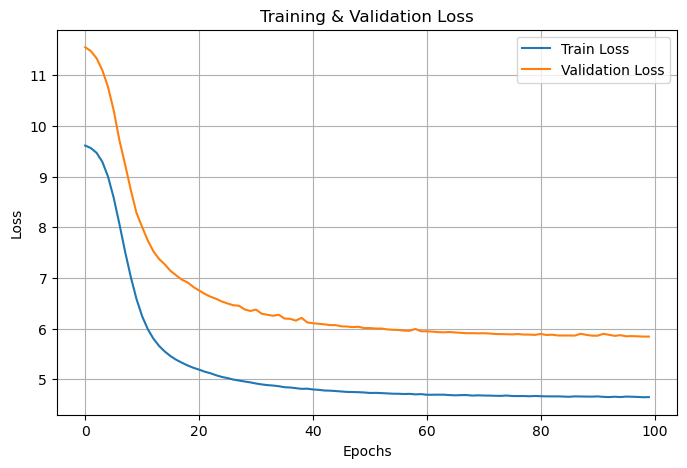

In [188]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, valid_losses):
    """Train / Validation Loss 그래프"""
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()
plot_losses(train_losses, valid_losses)


In [189]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
def draw_scatter(test_y, predictions, rmse, corr):

    fig = px.scatter(x=test_y, y=predictions, labels={'x': 'Actual', 'y': 'Predicted'}, 
                    title=f'Real vs Predicted (RMSE: {rmse:.2f}, Corr: {corr:.2f})')
    fig.update_layout(
        xaxis=dict(scaleanchor="y", range=[-15, 15]),
        yaxis=dict(scaleanchor="x", range=[-15, 15]),
        width = 600,
        height = 600
    )

    fig.update_traces(marker=dict(size=2, opacity=0.6, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))
    fig.show()

def draw_ts(test_y, predictions, datetime, rmse, corr):
    fig = go.Figure()

    # 실제값과 예측값 시각화
    fig.add_trace(go.Scatter(x=datetime, y=test_y, mode='lines', name='Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=datetime, y=predictions, mode='lines', name='Predicted', line=dict(color='red')))

    fig.update_layout(
        title=f'Real vs Predicted (RMSE: {rmse:.2f}, Corr: {corr:.2f})'
    )
    fig.show()

In [190]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

test_y = test_y.flatten()
y_pred = y_pred.flatten()

rmse = np.sqrt(mean_squared_error(test_y, y_pred))
corr, _ = pearsonr(test_y, y_pred)

# draw_scatter(predictions, test_y, rmse, corr)
draw_ts(test_y , y_pred, datetime, rmse, corr)
print(corr, rmse)

0.7366527099312574 2.2406073
